###  K_nearest Neighbors Modelling

### Import relevant libaries and preprocessed dataset

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn import ensemble
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn import neighbors

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from joblib import dump, load
from tabulate import tabulate

In [5]:
df = pd.read_csv('weatherAUS_imputed.csv')
df.head()

,Date,Location,Year,Month,RainToday,RainTomorrow,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindGustDir_angle,Latitude,Longitude,Cloud,Pressure,Temperature,Humidity,temp_fluctuation
0,2009-01-01,Cobar,2009,1,0.0,0.0,-0.254034,1.452543,1.231645,0.544048,0.367568,-0.016581,0.134517,-0.346762,-1.566909,1.483789,-2.239319,1.266185
1,2009-01-02,Cobar,2009,1,0.0,0.0,-0.254034,2.092290,1.417426,-0.274399,0.142577,-0.016581,0.134517,-1.337620,-0.534263,0.523016,-2.103988,-0.123978
2,2009-01-03,Cobar,2009,1,0.0,0.0,-0.254034,1.589632,1.497046,-0.795229,-0.307405,-0.016581,0.134517,-1.337620,-0.664246,1.892307,-2.753579,1.531952
3,2009-01-04,Cobar,2009,1,0.0,0.0,-0.254034,1.178365,0.780464,0.395239,-1.432358,-0.016581,0.134517,-0.346762,-0.787008,1.756134,-1.400263,1.450178
4,2009-01-05,Cobar,2009,1,0.0,0.0,-0.254034,1.315454,1.205105,-0.720824,1.267530,-0.016581,0.134517,-0.544934,-0.765344,1.839351,-1.535595,1.102637


In [4]:
#Before starting the modelling process we will define a function to display the confusion matrix and classification_report 
def confusion_matrix_classification_report(y_test, y_pred_test, y_train, y_pred_train):
    #calculate confusion matrix 
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font scale if needed
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Confusion Matrix')
    plt.show()

    # Generate classification report
    report = classification_report(y_test, y_pred_test)

    # Print the classification report
    print('-------------------------')
    print(report)

    # Calculate accuracy for both sets
    print('-------------------------')
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    print("Accuracy Train Set:", np.round(train_accuracy,3), "Accuracy Test Set:", np.round(test_accuracy,3))

### K_nearest neighbors

### 1. Without over or undersampling 

In [6]:
data = df.drop(columns=['RainTomorrow','Location','Date'])
target = df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

### 1.1 Default KNN model with n_neighbors 5 and Minkowski

In [7]:
knn = neighbors.KNeighborsClassifier(n_neighbors=5, metric='minkowski')
knn.fit(X_train,y_train)

KNeighborsClassifier()

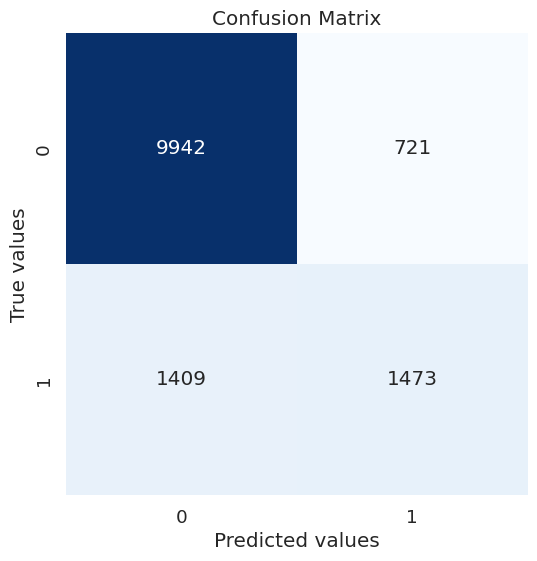

-------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90     10663
         1.0       0.67      0.51      0.58      2882

    accuracy                           0.84     13545
   macro avg       0.77      0.72      0.74     13545
weighted avg       0.83      0.84      0.83     13545

-------------------------
Accuracy Train Set: 0.889 Accuracy Test Set: 0.843


In [23]:
y_pred_mi = knn.predict(X_test)
y_pred_train_mi = knn.predict(X_train)
confusion_matrix_classification_report(y_test, y_pred_mi, y_train, y_pred_train_mi)

### 1.2 GridSearch 

In [15]:
knn_model = neighbors.KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 41), 'metric': ['minkowski','manhattan','chebyshev']}
nfolds = 5

In [17]:
grid_knn = GridSearchCV(knn_model, param_grid, cv=nfolds)

In [18]:
knn_fit = grid_knn.fit(X_train, y_train)

In [34]:
dump(knn_fit, 'knn_fit.joblib')

{'metric': 'manhattan', 'n_neighbors': 23}

In [2]:
knn_fit = load('knn_fit.joblib')
knn_fit.best_params_

{'metric': 'manhattan', 'n_neighbors': 23}

### 1.3 Model with best parameters 

In [38]:
# best parameters {'metric': 'manhattan', 'n_neighbors': 23}
knn_best = neighbors.KNeighborsClassifier(n_neighbors=23, metric="manhattan")
knn_best.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=23)

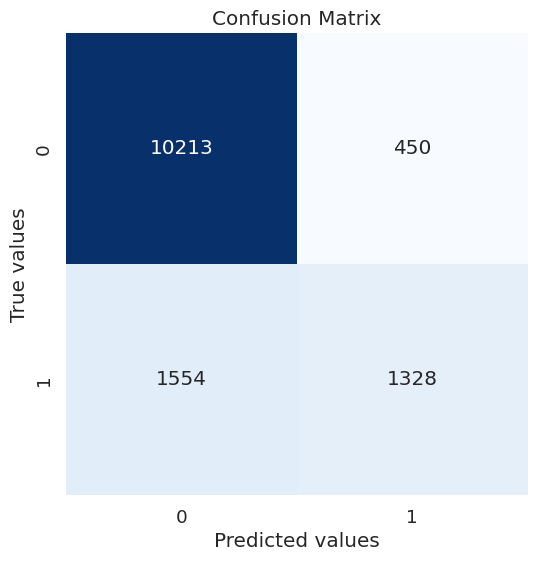

-------------------------
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91     10663
         1.0       0.75      0.46      0.57      2882

    accuracy                           0.85     13545
   macro avg       0.81      0.71      0.74     13545
weighted avg       0.84      0.85      0.84     13545

-------------------------
Accuracy Train Set: 0.863 Accuracy Test Set: 0.852


In [40]:
y_pred_best = knn_best.predict(X_test)
y_pred_train_best = knn_best.predict(X_train)
confusion_matrix_classification_report(y_test, y_pred_best, y_train, y_pred_train_best)

### 2. With over sampling 

In [8]:
df = pd.read_csv('weatherAUS_imputed.csv')
df.head()
data = df.drop(columns=['RainTomorrow', 'Location', 'Date'])
target = df['RainTomorrow']

### 2.1 RandomOverSampling

In [9]:
ros = RandomOverSampler()
sample_ros = ros.fit_resample(data,target)

In [10]:
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(sample_ros[0], sample_ros[1], test_size=0.2, random_state=20)

In [46]:
knn_ros = neighbors.KNeighborsClassifier(n_neighbors=23, metric="manhattan")
knn_ros.fit(X_train_ros, y_train_ros)

KNeighborsClassifier(metric='manhattan', n_neighbors=23)

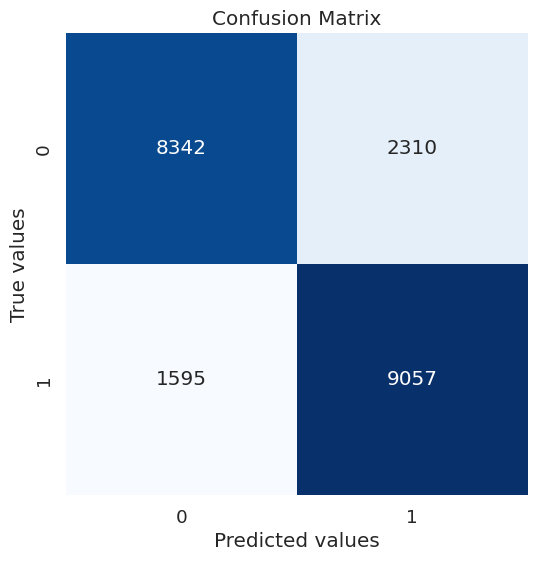

-------------------------
              precision    recall  f1-score   support

         0.0       0.84      0.78      0.81     10652
         1.0       0.80      0.85      0.82     10652

    accuracy                           0.82     21304
   macro avg       0.82      0.82      0.82     21304
weighted avg       0.82      0.82      0.82     21304

-------------------------
Accuracy Train Set: 0.836 Accuracy Test Set: 0.817


In [48]:
y_pred_ros = knn_ros.predict(X_test_ros)
y_pred_train_ros = knn_ros.predict(X_train_ros)


confusion_matrix_classification_report(y_test_ros, y_pred_ros, y_train_ros, y_pred_train_ros)

In [ ]:
dump(y_pred_ros, 'y_pred_ros_knn.joblib')
dump(y_pred_train_ros, 'y_pred_train_ros_knn.joblib')

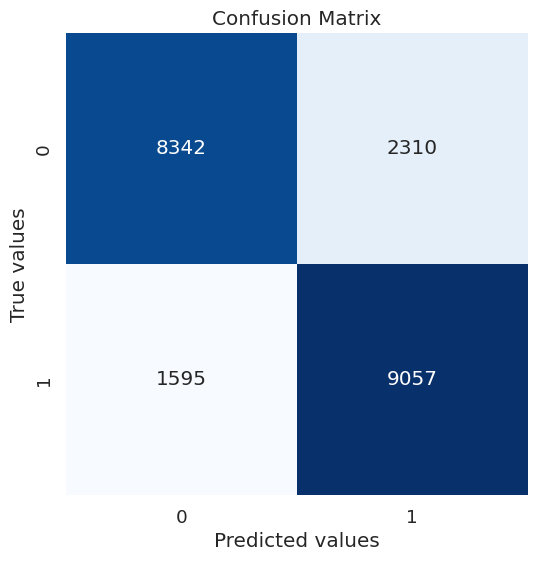

-------------------------
              precision    recall  f1-score   support

         0.0       0.84      0.78      0.81     10652
         1.0       0.80      0.85      0.82     10652

    accuracy                           0.82     21304
   macro avg       0.82      0.82      0.82     21304
weighted avg       0.82      0.82      0.82     21304

-------------------------
Accuracy Train Set: 0.836 Accuracy Test Set: 0.817


In [11]:
y_pred_ros_knn = load('y_pred_ros_knn.joblib')
y_pred_train_ros_knn = load('y_pred_train_ros_knn.joblib')
confusion_matrix_classification_report(y_test_ros, y_pred_ros_knn, y_train_ros, y_pred_train_ros_knn)

### 2.2 SMOTE

In [12]:
smo = SMOTE()
sample_sm = smo.fit_resample(data,target)

In [13]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(sample_sm[0], sample_sm[1], test_size=0.2, random_state=20)

In [52]:
knn_sm = neighbors.KNeighborsClassifier(n_neighbors=23, metric="manhattan")
knn_sm.fit(X_train_sm, y_train_sm)

KNeighborsClassifier(metric='manhattan', n_neighbors=23)

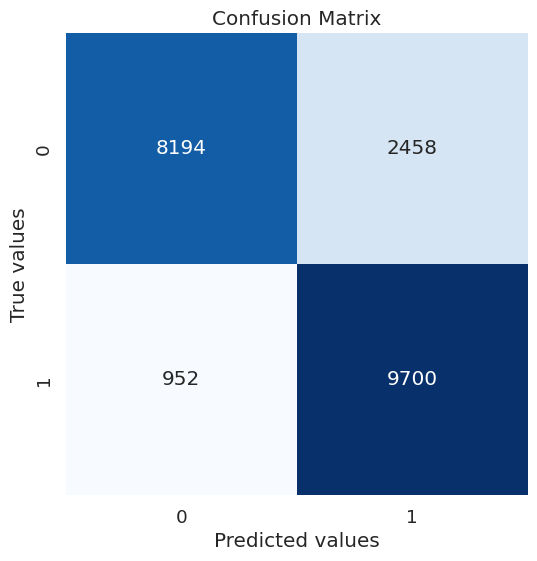

-------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.77      0.83     10652
         1.0       0.80      0.91      0.85     10652

    accuracy                           0.84     21304
   macro avg       0.85      0.84      0.84     21304
weighted avg       0.85      0.84      0.84     21304

-------------------------
Accuracy Train Set: 0.856 Accuracy Test Set: 0.84


In [53]:
y_pred_sm = knn_sm.predict(X_test_sm)
y_pred_train_sm = knn_sm.predict(X_train_sm)
confusion_matrix_classification_report(y_test_sm, y_pred_sm, y_train_sm, y_pred_train_sm)

In [ ]:
dump(y_pred_sm, 'y_pred_sm_knn.joblib')
dump(y_pred_train_sm, 'y_pred_train_sm_knn.joblib')

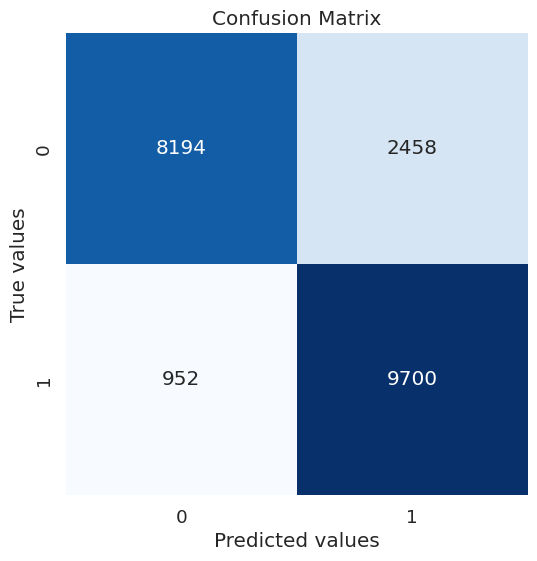

-------------------------
              precision    recall  f1-score   support

         0.0       0.90      0.77      0.83     10652
         1.0       0.80      0.91      0.85     10652

    accuracy                           0.84     21304
   macro avg       0.85      0.84      0.84     21304
weighted avg       0.85      0.84      0.84     21304

-------------------------
Accuracy Train Set: 0.856 Accuracy Test Set: 0.84


In [14]:
y_pred_sm_knn = load('y_pred_sm_knn.joblib')
y_pred_train_sm_knn = load('y_pred_train_sm_knn.joblib')
confusion_matrix_classification_report(y_test_sm, y_pred_sm_knn, y_train_sm, y_pred_train_sm_knn)

### 3. With undersampling 

### 3.1 RandomUnderSampler

In [22]:
rus = RandomUnderSampler()
sample_rus = rus.fit_resample(data,target)

In [16]:
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(sample_rus[0], sample_rus[1], test_size=0.2, random_state=20)

In [23]:
knn_rus = neighbors.KNeighborsClassifier(n_neighbors=23, metric="manhattan")
knn_rus.fit(X_train_rus, y_train_rus)

KNeighborsClassifier(metric='manhattan', n_neighbors=23)

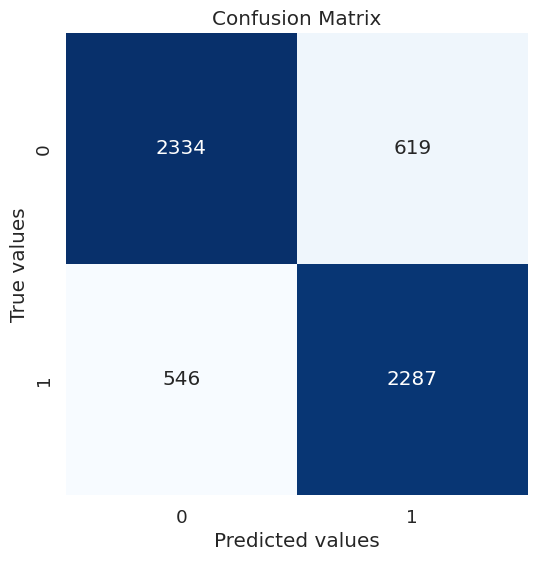

-------------------------
              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80      2953
         1.0       0.79      0.81      0.80      2833

    accuracy                           0.80      5786
   macro avg       0.80      0.80      0.80      5786
weighted avg       0.80      0.80      0.80      5786

-------------------------
Accuracy Train Set: 0.816 Accuracy Test Set: 0.799


In [24]:
y_pred_rus = knn_rus.predict(X_test_rus)
y_pred_train_rus = knn_rus.predict(X_train_rus)
confusion_matrix_classification_report(y_test_rus, y_pred_rus, y_train_rus, y_pred_train_rus)

In [25]:
dump(y_pred_rus, 'y_pred_rus_knn.joblib')
dump(y_pred_train_rus, 'y_pred_train_rus_knn.joblib')

['y_pred_train_rus_knn.joblib']

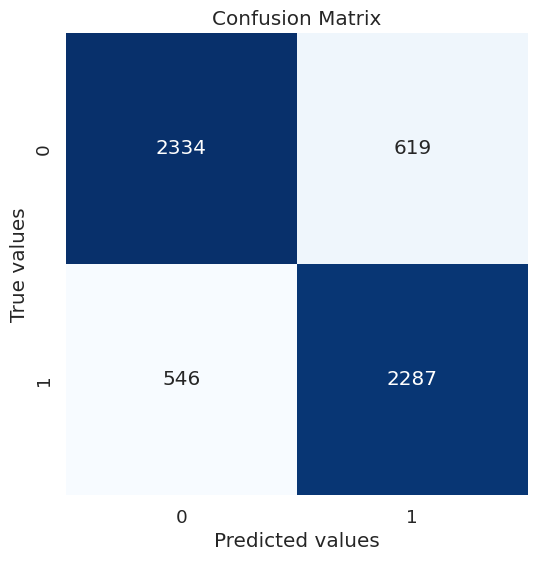

-------------------------
              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80      2953
         1.0       0.79      0.81      0.80      2833

    accuracy                           0.80      5786
   macro avg       0.80      0.80      0.80      5786
weighted avg       0.80      0.80      0.80      5786

-------------------------
Accuracy Train Set: 0.816 Accuracy Test Set: 0.799


In [26]:
y_pred_rus_knn = load('y_pred_rus_knn.joblib')
y_pred_train_rus_knn = load('y_pred_train_rus_knn.joblib')
confusion_matrix_classification_report(y_test_rus, y_pred_rus_knn, y_train_rus, y_pred_train_rus_knn)

### 4. Conclusion Over/Undersampling

The scores from Random Oversampling and SMOTE are quite similar. But the precision, recall and f1 scores are higher for class 0 when using SMOTE. Undersampling performs significantly less well. 

### 5.  Hyperparameter tuning with SMOTE

### 5.1 GridSearchCV

In [69]:
knn_model = neighbors.KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 30), 'metric': ['manhattan']}
nfolds = 5

In [70]:
grid_knn_sm = GridSearchCV(knn_model, param_grid, cv=nfolds)
knn_fit_sm = grid_knn_sm.fit(X_train_sm, y_train_sm)

In [ ]:
dump(knn_fit_sm, 'knn_fit_sm.joblib')

In [27]:
knn_fit_sm = load('knn_fit_sm.joblib')
knn_fit_sm.best_params_

{'metric': 'manhattan', 'n_neighbors': 1}

### 5.2 Best Parameters Fit

In [29]:
knn_sm_best = neighbors.KNeighborsClassifier(n_neighbors=1, metric="manhattan")
knn_sm_best.fit(X_train_sm, y_train_sm)

KNeighborsClassifier(metric='manhattan', n_neighbors=1)

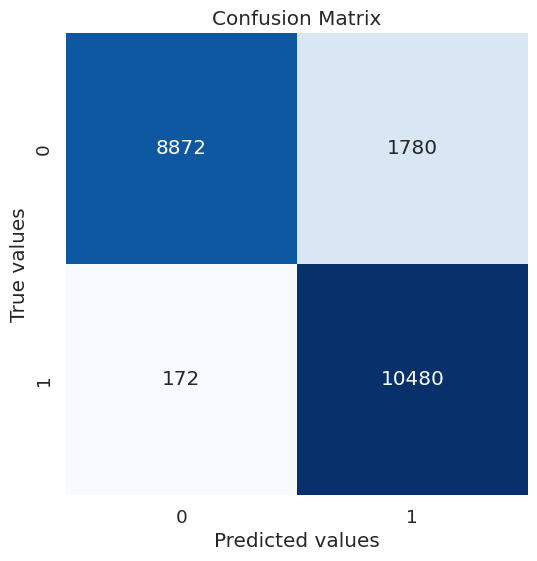

-------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90     10652
         1.0       0.85      0.98      0.91     10652

    accuracy                           0.91     21304
   macro avg       0.92      0.91      0.91     21304
weighted avg       0.92      0.91      0.91     21304

-------------------------
Accuracy Train Set: 1.0 Accuracy Test Set: 0.908


In [73]:
y_pred_best = knn_sm_best.predict(X_test_sm)
y_pred_train_best = knn_sm_best.predict(X_train_sm)
confusion_matrix_classification_report(y_test_sm, y_pred_best, y_train_sm, y_pred_train_best)

### 7. Cross Validation 

In [86]:
scoring = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted')
}

cv_results = cross_validate(knn_sm_best, X_train_sm, y_train_sm, cv=10, return_estimator=True, scoring=scoring)

In [81]:
fold_numbers = range(1,11)
test_precision = cv_results['test_precision']
test_recall = cv_results['test_recall']
test_f1_score = cv_results['test_f1_score']
table = [["Fold", "Test Precision", "Test Recall", "Test F1-Score"]]
for fold, prec, recall, f1 in zip(fold_numbers, test_precision, test_recall, test_f1_score):
    table.append([fold, f"{prec:.3f}", f"{recall:.3f}", f"{f1:.3f}"])

# Print table
print(tabulate(table, headers="firstrow", tablefmt="pretty"))

+------+----------------+-------------+---------------+
| Fold | Test Precision | Test Recall | Test F1-Score |
+------+----------------+-------------+---------------+
|  1   |     0.920      |    0.911    |     0.911     |
|  2   |     0.914      |    0.906    |     0.905     |
|  3   |     0.921      |    0.913    |     0.913     |
|  4   |     0.914      |    0.904    |     0.903     |
|  5   |     0.916      |    0.907    |     0.907     |
|  6   |     0.909      |    0.899    |     0.898     |
|  7   |     0.920      |    0.913    |     0.912     |
|  8   |     0.916      |    0.907    |     0.906     |
|  9   |     0.921      |    0.913    |     0.913     |
|  10  |     0.913      |    0.903    |     0.903     |
+------+----------------+-------------+---------------+


### 8. Conclusion 

We get the best performance with SMOTE and hyperparameter tuning where n_neighbor=1 and the distance chosen is 'manhattan'. The hyperparameter tuning greatly improved the results especially for the precision and recall score of class 0 and the recall score of class 1. 

Precision: For class 0, the precision is 0.98, indicating that out of all instances predicted as class 0, 98% were actually class 0. Similarly, for class 1, the precision is 0.85, meaning that out of all instances predicted as class 1, 85% were actually class 1.

Recall: For class 0, the recall is 0.83, indicating that out of all instances that were actually class 0, 83% were correctly predicted as class 0. For class 1, the recall is 0.98, meaning that 98% of instances that were actually class 1.0 were correctly predicted as class 1.

F1-score: The F1-score, which is the harmonic mean of precision and recall, is 0.90 for class 0 and 0.91 for class 1. These scores indicate a balance between precision and recall for both classes.

Accuracy: The overall accuracy of the model is 0.91, meaning that the model correctly classified 91% of all instances.

Macro Average: The macro average of precision, recall, and F1-score is 0.92, indicating a high performance for both classes when averaged equally.

Weighted Average: The weighted average of precision, recall, and F1-score is also 0.91, taking into account the number of true instances for each class. This suggests that the model performs well overall, with similar performance for both classes.

Overall, this KNN with SMOTE and hyperparameter tuning shows strong performance, with high precision and recall for both classes and an overall accuracy of 91%. It demonstrates the ability to effectively classify instances into their respective classes.

The cross validation results suggest that the best model performs consistently across different folds of the dataset, with precision, recall, and F1-score values ranging between 0.909 to 0.921, 0.899 to 0.913, and 0.898 to 0.913, respectively. This consistency indicates that the model generalizes well to unseen data and is likely to perform consistently on new datasets.